# Question 2: Training and using materials models
**2.1 data cleaning and splitting**

In a Materials informatics workflow you need to find and clean data, featurize the data, train models, and use models for some task. A few years ago, we put together a nice series of notebooks that describe this process for an example where we train heat capacity data as a function of temperature and composition and then use this model to predict heat capacity as a function of temperature for new materials. The best practices document is a great starting point for you and can be found here `https://github.com/anthony-wang/BestPractices`. I'd like you to go through a similar exercise as the best practices notebook but with a few changes. 

**<font color='teal'>a)</font>** First, you'll notice that the original notebooks used `pandas-profiling` but this has been deprecated and replaced by ydata-profiling. Try to get ydata-profiling to work and then use it to inspect your data. 

In [2]:
# Read in the Cp data and run the profiling
import pandas as pd
from ydata_profiling import ProfileReport

orig_df = pd.read_csv("cp_data_demo.csv")
profile = ProfileReport(orig_df, title="Profiling Report")
profile


C:\Users\byron\AppData\Local\Temp\ipykernel_3068\2070421362.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The ydata-profiler shows that there are negative values for temperature and Cp as well as missing and duplicate records.
I like this profiler more than the data wrangler as it is easier (for me anyway) to analyze the data


In [3]:
# Print out the columns as they likely need to be renamed
orig_df.columns

Index(['FORMULA', 'CONDITION: Temperature (K)',
       'PROPERTY: Heat Capacity (J/mol K)'],
      dtype='object')

In [4]:
# Change column names for easier use and so we can use the CBFV featurizer later

rename_dict = {'FORMULA': 'formula',
               'CONDITION: Temperature (K)': 'T',
               'PROPERTY: Heat Capacity (J/mol K)': 'target'}

orig_df = orig_df.rename(columns = rename_dict)
orig_df.columns

Index(['formula', 'T', 'target'], dtype='object')

In [5]:
# Clean the data

clean_df = orig_df.copy()
print(f"Original shape = {clean_df.shape}")

#remove records with missing data
clean_df = clean_df.dropna()
print(f"After dropping NaN = {clean_df.shape}")

# remove duplicate records
clean_df = clean_df.drop_duplicates() 
print(f"After removing duplicates = {clean_df.shape}")

bool_bad_T = clean_df['T']<0
clean_df = clean_df.drop(clean_df.loc[bool_bad_T].index,axis=0)
print(f"After removing bad T data = {clean_df.shape}")

bool_bad_Cp = clean_df['target']<0
clean_df = clean_df.drop(clean_df.loc[bool_bad_Cp].index,axis=0)
print(f"After removing bad Cp data = {clean_df.shape}")


Original shape = (4583, 3)
After dropping NaN = (4570, 3)
After removing duplicates = (4553, 3)
After removing bad T data = (4550, 3)
After removing bad Cp data = (4547, 3)


In [6]:
# Similar to the example notebook, will output cleaned data to a CSV file
import os

out_path = os.path.join(os.getcwd(), 'HW2_Q2_data/cp_data_cleaned.csv')
clean_df.to_csv(out_path, index=False)


**<font color='teal'>b)</font>** Second, in the data-splitting notebook, you'll see how we came up with an elaborate way to make sure tha as we split the data, we made sure that all the values corresponding to a formula went to either test, val, or train but would never be randomly split across these groups. We were silly and didn't know about `GroupKFold` in teh scikit-learn library. (`https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html`) Redo the splitting process using this much simpler tool. 


<span style="color:lightblue">
Initially I used the GroupKFold method, but after reviewing the original notebooks, I notice they split into 70/20/10 splits for training/validation/testing sets.
I left this code here, but commented it out

After discussion with ChatGPT's Python Machine Learning Expert GPT, I will initially split the data into a 90/10 training/test sets.
Then, we can use the GroupKFold for cross validation across the training set before finally training models on the full training sets.

Alternatively could do a GroupKFold with n_splits=10 
</span>


In [7]:
# from sklearn.model_selection import GroupKFold

# # Assuming 'formula' is the column based on which you want to group your folds
# groups = clean_df['formula']  # This will ensure all rows with the same formula are in the same split

# # Initialize the GroupKFold
# gkf = GroupKFold(n_splits=5)

# # Create an iterator that can be used to go through the 5 splits individually
# iterator = gkf.split(clean_df, groups=groups)

# # can call this line later to get the next split - call multiple times until an exception occurs   
# # This allows for cross-validation to be performed later easily
# train_index, test_index = next(iterator)

# train_df = clean_df.iloc[train_index]
# test_df = clean_df.iloc[test_index]
# print(f"Train = {train_df.shape},  Test = {test_df.shape}")


The following code was used to verify behavior of checking that the GroupKFold and  GroupShuffleSplit functions worked correctly. 

In [8]:
# # Standard splitting without using the GroupKFold
# # This was used for verification of the need for grouping prior to splitting the data

# from sklearn.model_selection import train_test_split
# X = clean_df.drop(columns=['Cp'])
# y = clean_df['Cp']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# train_df = X_train
# test_df = X_test
# # 

Now, the code for the GroupShuffleSplit

In [9]:
# 
from sklearn.model_selection import GroupShuffleSplit

# Create the shuffle split iterator with 1 item
gss = GroupShuffleSplit(test_size=0.1, n_splits=1, random_state=42)
train_index, test_index = next(gss.split(clean_df, groups=clean_df['formula']))

train_df = clean_df.iloc[train_index]
test_df = clean_df.iloc[test_index]

print(f"Train shape = {train_df.shape}.  Test shape = {test_df.shape}")


Train shape = (4072, 3).  Test shape = (475, 3)


In [10]:
# This code prints wherever a formula is split found in both the test and train splits
# used after running one of the code blocks above
# Verifies that my formulae were all grouped properly in the split sets

train_formulas = set(train_df['formula'].unique())
test_formulas = set(test_df['formula'].unique())
common_formulas = train_formulas.intersection(test_formulas)

common_formulas


set()

**2.2 model training and hyper parameter tuning**

**<font color='teal'>c)</font>** Next, when we built our classic models, we never performed hyperparameter tuning! We just used them with default parameters. I'd like you to build two models and perform hyperparameter tuning on them. One model should be either `Ridge` or `Lasso` and the other should be `XGBoost`. Compare performance metrics including training time. 

In [11]:
# Featurize the data from the formulae while keeping the T data by extending the features
from CBFV.composition import generate_features

X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(train_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(test_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)


Processing Input Data:   0%|          | 0/4072 [00:00<?, ?it/s]

Processing Input Data: 100%|██████████| 4072/4072 [00:00<00:00, 14255.19it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 4072/4072 [00:00<00:00, 9539.59it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 475/475 [00:00<00:00, 20084.42it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 475/475 [00:00<00:00, 9594.07it/s]


	Creating Pandas Objects...


In [12]:
# checks to ensure number of rows is unchanged and skipped_train is unchanged
print(f"X train shape = {X_train_unscaled.shape}.  train_df shape = {train_df.shape}.  y_train = {y_train.shape}")
skipped_train

X train shape = (4072, 309).  train_df shape = (4072, 3).  y_train = (4072,)


[]

Because there were no skipped values in my skipped set, I can add the formula column back into my featurized set so I can group on that.

I am thinking now that the formulae_train object that was ouput by the CBFV featurizer likley contains the original formulae and I could have used that for either grouping by indices or adding the formulae back into my featurized dataset.


In [13]:
# add the formula column back in so I can do my group k fold splitting
X_train_unscaled['formula'] = train_df['formula'].values
X_train_unscaled.shape


C:\Users\byron\AppData\Local\Temp\ipykernel_3068\3954902624.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_unscaled['formula'] = train_df['formula'].values


(4072, 310)

Next, I use GroupKFold to split my training data sets into 5 folds of training and validtaion sets
I will use those for cross validations

In [14]:
from sklearn.model_selection import GroupKFold

groups = X_train_unscaled['formula']  # This extracts the group keys

# Initialize the GroupKFold with 5 splits
gkf = GroupKFold(n_splits=5)

# Prepare lists to store split data
X_train_splits = []
y_train_splits = []
X_val_splits = []
y_val_splits = []

# Splitting the DataFrame using GroupKFold
for train_index, val_index in gkf.split(X_train_unscaled, y_train, groups=groups):
    # For each split, extract the training and validation sets for X and y
    X_train_split = X_train_unscaled.iloc[train_index].drop(columns=['formula'])
    y_train_split = y_train.iloc[train_index]
    
    X_val = X_train_unscaled.iloc[val_index].drop(columns=['formula'])
    y_val = y_train.iloc[val_index]
    
    # Store the split datasets in their respective lists
    X_train_splits.append(X_train_split)
    y_train_splits.append(y_train_split)
    X_val_splits.append(X_val)
    y_val_splits.append(y_val)

# At this point, X_train_splits, y_train_splits, X_val_splits, and y_val_splits contain your split datasets
# Each list contains 5 DataFrames corresponding to the 5 folds
# For example, to access the first fold's training and validation sets, you would use X_train_splits[0], y_train_splits[0], etc.


In [15]:

# Print the shape of each of the K splits for the x and y training sets and validation sets
print(f"X_train\t\ty_train\t\tx_val\t\ty_val")
for xsplit, ysplit, x_val, y_val in zip(X_train_splits, y_train_splits,X_val_splits, y_val_splits):
    print(f"{xsplit.shape}\t{ysplit.shape}\t\t{x_val.shape}\t{y_val.shape}")


X_train		y_train		x_val		y_val
(3256, 309)	(3256,)		(816, 309)	(816,)
(3259, 309)	(3259,)		(813, 309)	(813,)
(3257, 309)	(3257,)		(815, 309)	(815,)
(3257, 309)	(3257,)		(815, 309)	(815,)
(3259, 309)	(3259,)		(813, 309)	(813,)


<span style="color: lightblue;">
Now I have all the featurized data split into the k folds, I can iterate through and scale my features in each fold

The only issue here I can see is that my test data set is the same for each of the 5 folds.  
I will proceed like this for now.  Unsure if this is necessarily a bad thing.

It is likely not a problem. 
I will do the cross validation on the 90% training split then evalute the fits at the end on the 10% test splie
</span>

<span style="color: lightblue;">First, I am going to try to set up and use the functions defined in the original notebook.
This should make it significantly easier to run through multiple splits in a loop getting evaluation data for cross validation
</span>

Below I took the function definitions from the original example notebook and modified them as appropriate.


In [16]:
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error


# Wrapper function used to instantiate models.  
# Most simple instantiation is simply model()
# Used so it can be expanded to include more difficult to instantiate models in the future
# returns the instantiated model ready to train
def instantiate_model(model_name, param_dict):
    if param_dict == None or param_dict == "":
        model = model_name()
    else:
        model = model_name(**param_dict)
    return model

# Given a model name and X, y training data, trains the model returning the trained model and time it took to train
def fit_model(model, param_dict, X_train, y_train):
    ti = time()
    model = instantiate_model(model, param_dict)
    model.fit(X_train, y_train)
    fit_time = time() - ti
    return model, fit_time

# When given a trained model with real X and y data, will generate y_pred predicted values
# and compare to actual data returning the R2, mean absolute error, and root mean squared error for the fit
def evaluate_model(model, X, y_act):
    y_pred = model.predict(X)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = root_mean_squared_error(y_act, y_pred)
    return r2, mae, rmse_val

# This is called by feeding the model to be used, the name of the model 
# as well as the X and y training and validation data sets 
# Returns a trained model and a dictionary of evaluation metrics
def fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_act_val, param_dict=None):
    model, fit_time = fit_model(model, param_dict, X_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict


# # Used to append a record to a dataframe, df, with a dictionary containing one record
# # The good thing about having this function is past code can be reused and you only have
# # to modify this function to get it working with new versions
def append_result_df(df, result_dict):
    new_df = pd.DataFrame([result_dict])
    df_result_appended = pd.concat([df, new_df], ignore_index=True)
    return df_result_appended


# Quick function to add a trained model to a model dictionary
def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic


In [17]:
# Generate a df to hold the metrics for each model for each fold being evaluated
model_metrics_df = pd.DataFrame(columns=['model_name',
                                    'model_name_pretty',
                                    'model_params',
                                    'fold_num',
                                    'fit_time',
                                    'r2_train',
                                    'mae_train',
                                    'rmse_train',
                                    'r2_val',
                                    'mae_val',
                                    'rmse_val'])
model_metrics_df

Empty DataFrame
Columns: [model_name, model_name_pretty, model_params, fold_num, fit_time, r2_train, mae_train, rmse_train, r2_val, mae_val, rmse_val]
Index: []

If additional models need to be evaluated, they can be added here

In [18]:
# import everything needed for the models I will use and create an ordered dictionary 
# that links an abbreviated name to the class needed to instantiate the model
#
from collections import OrderedDict
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

model_names = OrderedDict({
    'rr': Ridge,
    'ls':Lasso,
    'xgb':XGBRegressor
})

Below we start with the hyperparameter tuning.
I will perform this on the first split in my kFold splits.

In hind sight I probably should have used my full 90% training data set for this as this method already includes cross validation


In [20]:
# First, I will extract the first split of data and scale it so it can be used to tune hyperparameters of models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

scaler = StandardScaler()   # Set up the scaler as the STandardScaler

 # use the standard scaler to get the fit and transform all the X data sets
X_train = scaler.fit_transform(X_train_splits[0])       #the train and val splits were done on unscaled data
X_val = scaler.transform(X_val_splits[0])
    # Normalize all of the X datasets
X_train = normalize(X_train)
X_val = normalize(X_val)
y_train = y_train_splits[0]
y_val = y_val_splits[0]


The code below is for tuning the XGBoost model
I did not set up a loop to go through each model as it was easier in this case to simply run the tuning on each model individually
I set these tuning parameters to run 100 iterations with 5-fold cross validation
Set these to run overnight which worked, then I manually took the best parameters found for each model and commented out the tuning code.

In [ ]:
# # Tune parameters of XGBoost model
# from xgboost import XGBRegressor
# from sklearn.model_selection import RandomizedSearchCV

# # Define your XGBoost model
# model = XGBRegressor()

# # First round of tuning the general parameters
# general_param_dist = {
#     'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  
#     'n_estimators': [50, 100, 200, 300, 500],  
#     'max_depth': [3, 4, 6, 8, 10, 12],  
# }
# # Run the optimization on the general parameters
# param_dist = general_param_dist
# general_xgb_search = RandomizedSearchCV(model, param_dist, cv = 5, n_iter=100, verbose=2)
# general_xgb_search.fit(X_train, y_train)

# # Extract the bestgeneral parameters found 
# best_params = general_xgb_search.best_params_
# print("Best general parameters found: ", best_params)

# # Instantiate a new model with the best general params for tuning booster params
# model = XGBRegressor(**best_params)

# # Booster Parameters
# booster_param_dist = ({
#     'gamma': [0, 0.1, 0.5, 1, 1.5, 2],
#     'min_child_weight': [1, 5, 10],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'colsample_bylevel': [0.6, 0.8, 1.0],
#     'colsample_bynode': [0.6, 0.8, 1.0],
# })

# param_dist = booster_param_dist
# booster_xgb_search = RandomizedSearchCV(model, param_dist, cv = 5, n_iter=20, verbose=2)
# booster_xgb_search.fit(X_train, y_train)

# best_params.update(booster_xgb_search.best_params_)
# print("The best parameters were found: ",best_params)

# xgb_best_params = best_params

In [21]:
# After running the code above, the best parameters were output, but then my computer restarted
# Rather than run it again, this code just sets the best params

xgb_best_params = {
    'n_estimators': 300,
    'max_depth': 3, 
    'learning_rate': 0.2, 
    'subsample': 1.0, 
    'min_child_weight': 10, 
    'gamma': 1.5, 
    'colsample_bytree': 1.0, 
    'colsample_bynode': 0.8, 
    'colsample_bylevel': 0.6
    }

The best parameters were found:  for XGBoost
    {'n_estimators': 300,
    'max_depth': 3, 
    'learning_rate': 0.2, 
    'subsample': 1.0, 
    'min_child_weight': 10, 
    'gamma': 1.5, 
    'colsample_bytree': 1.0, 
    'colsample_bynode': 0.8, 
    'colsample_bylevel': 0.6
    }

In [22]:
# from sklearn.linear_model import Lasso
# from sklearn.model_selection import RandomizedSearchCV

# # Define your XGBoost model
# model = Lasso()

# param_dist = {
#     'alpha': np.logspace(-4, 0, 50),  # Exploring a range of values from 0.0001 to 1
#     'max_iter': [5000, 10000, 20000],  # Optional: You might want to explore different values for max iterations
#     'selection': ['cyclic', 'random']  # Optional: Strategy to use for updating coefficients
# }

# lasso_search = RandomizedSearchCV(model, param_dist, cv = 5, n_iter=100, verbose=2)
# lasso_search.fit(X_train, y_train)

# # Extract the bestgeneral parameters found 
# best_params = lasso_search.best_params_
# print("Best parameters found: ", best_params)

# lasso_best_params = best_params


After running 100 iterations with CV=5, best parameters for Lasso:
    'selection':'random,
    'max_iter':10000,
    'alpha':0.023299518105153717

In [23]:
# Same as above for XGB, this is for Lasso:

lasso_best_params = {
    'selection':'random',
    'max_iter':10000,
    'alpha':0.023299518105153717
}

In [24]:
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np

# # Define your Ridge model
# model = Ridge()

# # Define the hyperparameter space
# param_dist = {
#     'alpha': np.logspace(-4, 4, 50),  # Exploring a broader range of values for alpha
#     'max_iter': [5000, 10000, 20000],  # Optional: Different values for max iterations
#     # Ridge does not have a 'selection' parameter, so it's omitted
#     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Optional: Different solvers
# }

# # Initialize RandomizedSearchCV
# ridge_search = RandomizedSearchCV(
#     model, 
#     param_dist, 
#     cv=5, 
#     n_iter=100, 
#     verbose=2,
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# # Fit RandomizedSearchCV
# ridge_search.fit(X_train, y_train)

# # Extract the best parameters found 
# best_params = ridge_search.best_params_
# print("Best parameters found: ", best_params)

# ridge_best_params = best_params

Ridge best parameters found:  {'solver': 'sparse_cg', 'max_iter': 20000, 'alpha': 0.8286427728546842}

In [25]:
# Same as above for ridge params:
ridge_best_params = {
    'solver': 'sparse_cg', 
    'max_iter': 20000, 
    'alpha': 0.8286427728546842
}

<span style="color: lightblue;">
Above, we run hyperparamter tuning on one of the data splits
Below, we run cross-validation on the models with the hyperparameters tuned

The model evaluation functions were modified to accept a list of model parameters 
Then the best params found above are put into a dictionary for use in the loop
</span>

In [26]:
model_names
model_params = {
    'rr':ridge_best_params,
    'ls':lasso_best_params,
    'xgb':xgb_best_params
}

In [27]:
model_params

{'rr': {'solver': 'sparse_cg', 'max_iter': 20000, 'alpha': 0.8286427728546842},
 'ls': {'selection': 'random',
  'max_iter': 10000,
  'alpha': 0.023299518105153717},
 'xgb': {'n_estimators': 300,
  'max_depth': 3,
  'learning_rate': 0.2,
  'subsample': 1.0,
  'min_child_weight': 10,
  'gamma': 1.5,
  'colsample_bytree': 1.0,
  'colsample_bynode': 0.8,
  'colsample_bylevel': 0.6}}

This is the code that loops through each of my kfold splits and runs the standard scalar on the data for that split, normalizes the features and then runs each model on the data.
The evaluation metrics are then appended to a df for review

In [28]:
# Now we can iterate through the folds training the standard scaler for each fold as needed
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

scaler = StandardScaler()   # Set up the scaler as the STandardScaler

for i in range(len(X_train_splits)):  # uncomment this to run through all 5 folds
# for i in range(0,1):                    # uncomment this to run through a single fold
    
    # use the standard scaler to get the fit and transform all the X data sets
    X_train = scaler.fit_transform(X_train_splits[i])       #the train and val splits were done on unscaled data
    X_val = scaler.transform(X_val_splits[i])
    
    # Normalize all of the X datasets
    X_train = normalize(X_train)
    X_val = normalize(X_val)

    y_train = y_train_splits[i]
    y_val = y_val_splits[i]

    # Loop through each model type, fit and predict, and evaluate and store results in the model_metrics_df including fold number
    for model_name, model in model_names.items():
        print(f'Now fitting and evaluating model {model_name}: {model.__name__} for fold {i+1}')
        model, result_dict = fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_val, model_params[model_name])
        result_dict['fold_num']=i+1
        model_metrics_df = append_result_df(model_metrics_df, result_dict)
        


Now fitting and evaluating model rr: Ridge for fold 1
Now fitting and evaluating model ls: Lasso for fold 1


C:\Users\byron\AppData\Local\Temp\ipykernel_3068\2518729230.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result_appended = pd.concat([df, new_df], ignore_index=True)


Now fitting and evaluating model xgb: XGBRegressor for fold 1
Now fitting and evaluating model rr: Ridge for fold 2
Now fitting and evaluating model ls: Lasso for fold 2
Now fitting and evaluating model xgb: XGBRegressor for fold 2
Now fitting and evaluating model rr: Ridge for fold 3
Now fitting and evaluating model ls: Lasso for fold 3
Now fitting and evaluating model xgb: XGBRegressor for fold 3
Now fitting and evaluating model rr: Ridge for fold 4
Now fitting and evaluating model ls: Lasso for fold 4
Now fitting and evaluating model xgb: XGBRegressor for fold 4
Now fitting and evaluating model rr: Ridge for fold 5
Now fitting and evaluating model ls: Lasso for fold 5
Now fitting and evaluating model xgb: XGBRegressor for fold 5


In [29]:
model_metrics_df

model_name model_name_pretty  \
0          rr             Ridge   
1          ls             Lasso   
2         xgb      XGBRegressor   
3          rr             Ridge   
4          ls             Lasso   
5         xgb      XGBRegressor   
6          rr             Ridge   
7          ls             Lasso   
8         xgb      XGBRegressor   
9          rr             Ridge   
10         ls             Lasso   
11        xgb      XGBRegressor   
12         rr             Ridge   
13         ls             Lasso   
14        xgb      XGBRegressor   

                                         model_params fold_num  fit_time  \
0   {'alpha': 0.8286427728546842, 'copy_X': True, ...        1  0.041108   
1   {'alpha': 0.023299518105153717, 'copy_X': True...        1  0.795633   
2   {'objective': 'reg:squarederror', 'base_score'...        1  1.803852   
3   {'alpha': 0.8286427728546842, 'copy_X': True, ...        2  0.034028   
4   {'alpha': 0.023299518105153717, 'copy_X': True...        2  1.919677   
5   {'objective': 'reg:squarederror', 'base_score'...        2  1.683694   
6   {'alpha': 0.8286427728546842, 'copy_X': True, ...        3  0.024304   
7   {'alpha': 0.023299518105153717, 'copy_X': True...        3  1.583893   
8   {'objective': 'reg:squarederror', 'base_score'...        3  1.592074   
9   {'alpha': 0.8286427728546842, 'copy_X': True, ...        4  0.024358   
10  {'alpha': 0.023299518105153717, 'copy_X': True...        4  1.571768   
11  {'objective': 'reg:squarederror', 'base_score'...        4  1.540445   
12  {'alpha': 0.8286427728546842, 'copy_X': True, ...        5  0.024329   
13  {'alpha': 0.023299518105153717, 'copy_X': True...        5  1.155712   
14  {'objective': 'reg:squarederror', 'base_score'...        5  1.593530   

    r2_train  mae_train  rmse_train    r2_val    mae_val   rmse_val  
0   0.904596  13.553037   21.135599  0.820339  15.243068  21.950392  
1   0.896176  14.414807   22.048515  0.821210  15.836001  21.897102  
2   0.995290   3.017925    4.696334  0.852816  14.291740  19.867645  
3   0.901223  13.059050   20.629619  0.826145  17.533794  26.934182  
4   0.889539  14.249969   21.815681  0.844677  16.708075  25.458244  
5   0.995352   2.984765    4.475235  0.904919  13.543172  19.918486  
6   0.887864  13.255717   21.233367  0.894854  17.429271  23.621062  
7   0.879792  14.042706   21.984326  0.898671  16.584739  23.188444  
8   0.994074   3.096769    4.881364  0.914446  13.597088  21.307128  
9   0.906086  12.757503   19.518716  0.813743  19.637798  30.602384  
10  0.897167  13.625671   20.424613  0.798927  20.620925  31.796242  
11  0.994680   3.029021    4.645698  0.870774  15.559646  25.490236  
12  0.896355  13.503020   21.178517  0.855988  15.433591  24.107009  
13  0.886948  14.536845   22.118846  0.849087  15.366519  24.677905  
14  0.994186   3.241639    5.016124  0.923445  11.588459  17.576472

Print the summary statistics from the cross-validation

In [31]:
import pandas as pd

# Assuming model_metrics_df is your DataFrame

# Group by model_name and calculate mean for each metric
summary_df = model_metrics_df.groupby('model_name').agg({
    'fit_time': 'mean',
    'r2_train': 'mean',
    'mae_train': 'mean',
    'rmse_train': 'mean',
    'r2_val': 'mean',
    'mae_val': 'mean',
    'rmse_val': 'mean'
}).reset_index()

# Display the summarized metrics
print(summary_df)


  model_name  fit_time  r2_train  mae_train  rmse_train    r2_val    mae_val  \
0         ls  1.405336  0.889924  14.174000   21.678396  0.842514  17.023252   
1         rr  0.029625  0.899225  13.225666   20.739164  0.842214  17.055504   
2        xgb  1.642719  0.994716   3.074023    4.742951  0.893280  13.716021   

    rmse_val  
0  25.403587  
1  25.443006  
2  20.831993  


I ran into an issue with the plots below and was advised to use this matplotlib inline command

In [34]:
%matplotlib inline

These box plots give a good visual output showing that XGBoost is significantly better over my training set

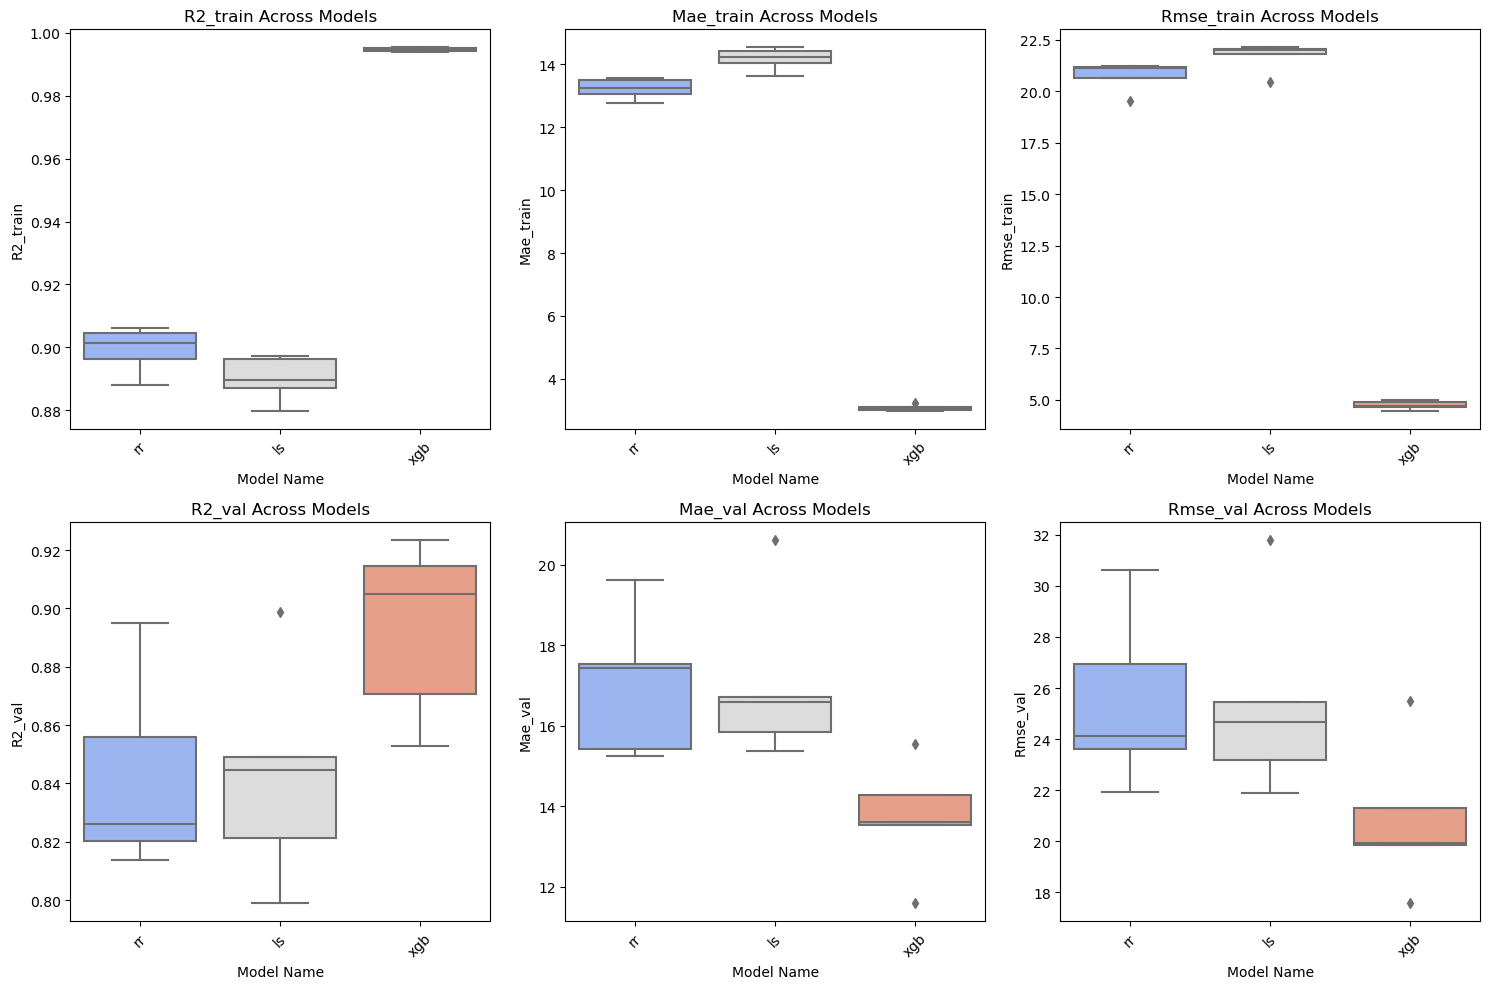

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming model_metrics_df is your DataFrame

# Group by model_name and calculate mean and std for each metric
summary_stats_df = model_metrics_df.groupby('model_name').agg({
    'fit_time': ['mean', 'std'],
    'r2_train': ['mean', 'std'],
    'mae_train': ['mean', 'std'],
    'rmse_train': ['mean', 'std'],
    'r2_val': ['mean', 'std'],
    'mae_val': ['mean', 'std'],
    'rmse_val': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex columns
summary_stats_df.columns = ['_'.join(col).rstrip('_') for col in summary_stats_df.columns.values]

# Setup the matplotlib figure and axes based on the number of metrics
metrics = ['r2_train', 'mae_train', 'rmse_train', 'r2_val', 'mae_val', 'rmse_val']
n_cols = 3
n_rows = int(np.ceil(len(metrics) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, metric in enumerate(metrics):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    sns.boxplot(x='model_name', y=metric, data=model_metrics_df, ax=ax, palette='coolwarm')
    ax.set_title(f'{metric.capitalize()} Across Models')
    ax.set_ylabel(f'{metric.capitalize()}')
    ax.set_xlabel('Model Name')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


Clearly the XGBoost model works much better for this dataset as shown by the 5-fold cross validation results above.

The train and test sets are created again from the initial split train_df and test_df
In my code between the previous CBFV call and here, my y_train df is no longer the full train set, but is a split from my kfold splitting.

This is only needed because I must have reassigned some of these variables from my initial featurization

In [43]:
# Featurize the data from the formulae while keeping the T data by extending the features
from CBFV.composition import generate_features

X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(train_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(test_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)


Processing Input Data: 100%|██████████| 4072/4072 [00:00<00:00, 10682.78it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 4072/4072 [00:00<00:00, 6334.73it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 475/475 [00:00<00:00, 11604.49it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 475/475 [00:00<00:00, 4186.45it/s]


	Creating Pandas Objects...


In [45]:
print(f"X_train shape = {X_train_unscaled.shape}.  y_train shape = {y_train.shape}")
print(f"X_test = {X_test_unscaled.shape}. y_test = {y_test.shape}")


X_train shape = (4072, 309).  y_train shape = (4072,)
X_test = (475, 309). y_test = (475,)


Scale and normalize the final test and train sets 

In [54]:
# scale and normalize the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

scaler = StandardScaler()   # Set up the scaler as the STandardScaler
X_train = scaler.fit_transform(X_train_unscaled)       #the train and val splits were done on unscaled data
X_test = scaler.transform(X_test_unscaled)
    
# Normalize all of the X datasets
X_train = normalize(X_train)
X_test = normalize(X_test)


Fit the xgb model

In [55]:
for model_name, model in model_names.items():
        if model_name == 'xgb':
            print(f'Now fitting and evaluating model {model_name}: {model.__name__}')
            model, result_dict = fit_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, model_params[model_name])        
        

Now fitting and evaluating model xgb: XGBRegressor


In [63]:
metrics = ['r2_train', 'mae_train', 'rmse_train', 'r2_val', 'mae_val', 'rmse_val']

for metric in metrics:
    print(f"{metric.replace('_', ' ').upper()}: {result_dict[metric]}")


R2 TRAIN: 0.9935424632833624
MAE TRAIN: 3.384663008658029
RMSE TRAIN: 5.25809027513136
R2 VAL: 0.9434960074849109
MAE VAL: 11.148077957876104
RMSE VAL: 18.070864511559254


Pretty good R2 on the test set

**2.3 using your model to make predictions**

**<font color='teal'>c)</font>** Finally, pick the best model from **2.2** and use it to predict the heat capacity from 1200K to 2000K for ZrN. See how it compares to experiment. 

![ZrN Cp](https://www.researchgate.net/publication/335403917/figure/fig2/AS:796198449467394@1566839911338/High-temperature-heat-capacity-Cp-of-zirconium-and-hafnium-carbides-and-carbonitrides.png)


Generate a data frame with my ZrN formula and a range of temperatures
Setting target to 0 arbitrarily

In [112]:
data = {
        'formula':[],
        'T':[],
        'target':[]
}
df = pd.DataFrame()
for i in range(120, 201):
    new_record = pd.DataFrame({
        'formula': ['ZrN'],
        'T': [i * 10],
        'target': [0]
    })
    df = pd.concat([df, new_record], ignore_index=True)

df

formula     T  target
0      ZrN  1200       0
1      ZrN  1210       0
2      ZrN  1220       0
3      ZrN  1230       0
4      ZrN  1240       0
..     ...   ...     ...
76     ZrN  1960       0
77     ZrN  1970       0
78     ZrN  1980       0
79     ZrN  1990       0
80     ZrN  2000       0

[81 rows x 3 columns]

Featurize teh ZrN formula

In [113]:
import pandas as pd
from CBFV.composition import generate_features

# Featurize the data from the formulae while keeping the T data by extending the features
X_unscaled, y, formulae, skipped = generate_features(df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)


Processing Input Data: 100%|██████████| 81/81 [00:00<00:00, 79994.97it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 81/81 [00:00<00:00, 5033.54it/s]

	Creating Pandas Objects...


In [114]:
# Need to scale the X and normalize it
X = scaler.transform(X_unscaled)
    
# Normalize all of the X datasets
X = normalize(X)


In [115]:
# Generate predicted Cp data
y_pred = model.predict(X)


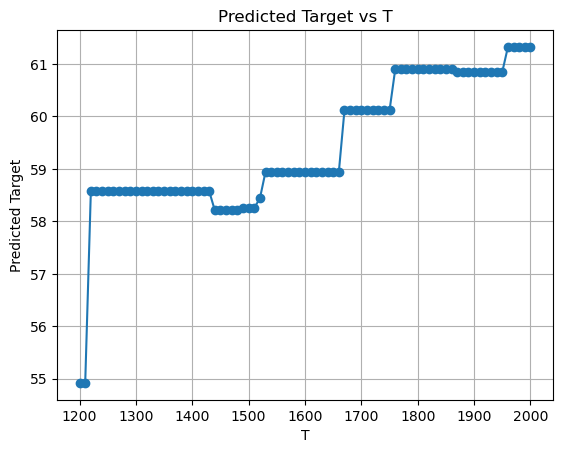

In [116]:
import matplotlib.pyplot as plt

# Assuming X is a DataFrame and contains the 'T' column
# Replace X with your actual feature data
T_values = X_unscaled['T']  # Extracting the 'T' column from X

# Plotting the T values versus the predicted target values
plt.plot(T_values, y_pred, marker='o', linestyle='-')
plt.xlabel('T')
plt.ylabel('Predicted Target')
plt.title('Predicted Target vs T')
plt.grid(True)
plt.show()


Interesting that the predicted values have this step-like shape
These values are in the ballpark of the reference data with a slight positive bias.

When I was going through adding more commentary before submission I realized I should have included all 3 ZrN formulae that were in the reference so I could compare trends between those.